# Reconhecimento de Género com Xception

Neste notebook será abordado o problema de reconhecimento de género, utilizando agora a rede Xception. Tal como nos notebooks passados, é preciso, numa fase inicial, carregar os dados dos ficheiros previamente criados. De seguida será feita a separação dos dados para treino/teste e por fim testar-se-á o sucesso da rede.

### Imports necessários

In [1]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from PIL import Image



## Recuperação dos dados dos ficheiros relativamente às imagens/labels

Leitura do ficheiro csv correspondente a todas as labels e anexação destas à lista results

In [2]:
import csv
results = []
with open("5kLabelsGender.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_ALL) # change contents to floats
    for row in reader: # each row is a list
        results.append(row)

In [24]:
labels = np.reshape(results,len(results))
labels

array(['1.0', '1.0', '0.0', ..., '0.0', '0.0', '1.0'], dtype='<U3')

Verificação da distribuição entre homens e mulheres (uma vez que é "significativa", pode levar a uma má aprendizagem da rede) 

In [22]:
import collections
collections.Counter(labels)

Counter({'1.0': 4137, '0.0': 1505})

Leitura do ficheiro relativo aos pontos das fotos.

Neste caso foi utilizado o que possuia 1/4 da informação do dataset (5642 fotos).
Este foi guardado num ficheiro binário por uma questão de redução de dimensão (uma vez que este contém 5642 * 256 * 256 floats)


In [ ]:
dadosLine = np.fromfile("5kGender")

In [5]:
teste = np.reshape(dadosLine,(5642,256,256))

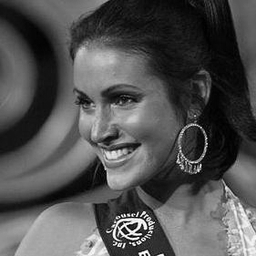

In [26]:
#Verificação da integridade dos dados -> foto reconstruível através dos pontos 
image2 = Image.fromarray((teste[20]*255).astype('uint8'))
image2

## Divisão dos dados para treino e teste

Uma vez que é necessária uma divisão do dataset para treino e teste, utilizamos o train_test_split com a flag de stratify (garantindo que a distribuição dos dados se mantém nas versões "reduzidas") e com random_state, permitindo assim que a operação se torne determinística (os mesmos dados irão ser divididos sempre para os mesmos conjuntos de treino e teste, enquanto que o valor desta flag se mantenha constante)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(teste,labels, test_size=0.15, stratify=labels,random_state = 2)

Uma vez dividido os dados, precisamos de os pré-processar antes de os dar a rede. Deste modo convertemos as labels dos dados em one-hot-encondig, correspondendo assim a um array de dimensão 2 (número de classes) com um 1 no índice da classe correspondente.

In [11]:
#1Hot encoding para as labels de treino
train_labels = pd.get_dummies(y_train)
test_labels = pd.get_dummies(y_test)

In [12]:
#1Hot encoding para as labels de teste
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [13]:
#Reshape para 4 dimensões (nFotos * 256pixeis * 256 pixeis * 1 canal de cor(black&white))
train_images = X_train.reshape((len(X_train), 256, 256, 1))
test_images = X_test.reshape((len(X_test), 256, 256, 1))

## Criação e treino da rede -> Xception 126layers

Tendo todos os dados carregados e prontos para passar à rede, podemos seguir para a contrução e treino da mesma. Assim, neste notebook, tal como referido anteriormente, utilizaremos a rede Xception. Esta pode ser definida através da sua API, especificando os parâmetros mais importantes tais como:

   * include_top => inclusão de uma camada completamente conetada no topo da rede
   * weights => pesos relativos aos neurónios (neste caso começo aleatório, em vez de uso de uma rede pré-treinada)
   * input_tensor => utilização de um tensor do Keras para utilização de imagens (desnecessário para o problema em questão)
   * input_shape => formato do input à rede (tal como referido anteriormente (256,256,1) -> 256pixeis * 256pixeis *1 canal)
   * pooling => como o include_top é True, não se utiliza este parâmetro
   * classes => número de classes existentes de output (2 => Género)

In [16]:
import tensorflow as tf

act = "softmax"

model = tf.keras.applications.Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(256,256,1),
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

In [28]:
#Verificação das camadas existentes na rede 
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Definição das métricas do modelo, "standard" para este problema de classificação

In [18]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])




Neste ponto, somos capazes de treinar a rede, todavia este é um processo lento e computacionalmente pesado. Assim, consideramos mais seguro e eficiente, a cada X epochs (2 neste caso) gravar o modelo. Deste modo, caso o kernel morra ou a conexão se perca (e.g., ligação ao colab ou a centro de processamento) pode-se carregar o modelo, até ao momento treinado, e prosseguir para as seguintes epochs. 

Uma vez que o número de dados é "reduzido" (5k fotos) consideramos que um batch size pequeno seria benéfico para uma melhor aprendizagem. Por fim consideramos também que com esta abordagem, ser-nos-ia mais fácil contornar o overfitting, uma vez que conseguiriamos aceder a modelos gerados antes de atingir esse ponto (que acaba por piorar a performance da rede)

In [30]:
for i in range (6,15):
    name = "XceptionGenderV" + str(i) + ".h5"
    model.fit(train_images, train_labels, epochs=3, batch_size=16)
    model.save(name)

Epoch 1/3
300/300 [==============================] - 113s 376ms/step - loss: 0.1680 - accuracy: 0.9379
Epoch 2/3
300/300 [==============================] - 115s 382ms/step - loss: 0.1533 - accuracy: 0.9424
Epoch 3/3
300/300 [==============================] - 117s 391ms/step - loss: 0.1301 - accuracy: 0.9508
Epoch 1/3
  4/300 [..............................] - ETA: 1:23 - loss: 0.1462 - accuracy: 0.9688

KeyboardInterrupt: 

Após o treino da rede, carregamos 3 modelos distintos de modo a comparar a performance destes.
O primeiro é obviamente antes de esta entrar em OF, crescimento da accuracy por epoch constante e diminuto;
O segundo era a meio do processo de entrar em OF, o crescimento era mais significativo, mas ainda estava efetivamente a aprender e não a especificar-se aos dados do dataset;
A terceira é já em OF, aumento de accuracy significativo, não por aprendizagem, mas por especificação, perdendo assim a capacidade de generalizar para novos dados (fácil de verificar que está em OF, pelos valores obtidos abaixo -> menos accuracy em teste).

Tal como se pode verificar embaixo e como seria de esperar, o melhor modelo foi o do meio, uma vez que teve mais "epochs" de aprendizagem, sem nunca ter efetuado OF, permitindo assim uma maior accuracy em dados nunca antes vistos (fase de teste)



In [53]:
from tensorflow.keras.models import load_model
model1 = load_model("XceptionGender4.h5")

In [54]:
model2 = load_model("XceptionGender5.h5")

In [55]:
model3 = load_model("XceptionGender6.h5")

In [56]:
test_loss, test_acc = model1.evaluate(test_images, test_labels)

27/27 [==============================] - 4s 142ms/step - loss: 0.3045 - accuracy: 0.8831


In [57]:
test_loss, test_acc = model2.evaluate(test_images, test_labels)

27/27 [==============================] - 4s 142ms/step - loss: 0.3105 - accuracy: 0.9138


In [58]:
test_loss, test_acc = model3.evaluate(test_images, test_labels)

27/27 [==============================] - 4s 143ms/step - loss: 0.2829 - accuracy: 0.8996


## Sistema de Inferência por imagem de input

Tendo a rede definida e com este grau de taxa de sucesso, podemos passar a uma utilização mais prática da rede, onde é possível carregar uma imagem local da máquina (que já se encontre em 256*256 pixeis) e testar a previsão da rede.

No exemplo abaixo a pessoa da foto é do sexo feminino, sendo esta a previsão da rede e com 92% de certeza (bastante certeza).

In [102]:
def predictGender(predictionsPOF):
        age = np.argmax(predictionsPOF)
        switcher={
                0:'MULHER, certeza: '+str((predictionsPOF[0][0]*100).astype('float16'))+" %",
                1:'HOMEM, certeza: '+str((predictionsPOF[0][1]*100).astype('float16'))+" %"
             }
        return switcher.get(age,"Invalid index")

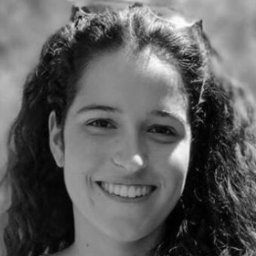

In [103]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3],[0.2989,0.5870,0.1140])


imgTeste = Image.open("59I.jpg")
data = np.asarray(imgTeste)/255
if(len(data.shape)>2):
    data = rgb2gray(data)
img =  Image.fromarray((data*255).astype('uint8'))
img2CNN =  data.reshape(1, 256, 256, 1)
img

In [104]:
predictGender(model2.predict(img2CNN))

'MULHER, certeza: 92.06 %'